In [1]:
#SQLite Db
import sqlite3
#dataframes
import pandas as pd
#array and matrix data structures
import numpy as np
#plots
import matplotlib.pyplot as plt
#lsq interpolation
import scipy.interpolate as si 
#for median
import statistics

In [2]:
# Create the connection.
cnx = sqlite3.connect('data_2.db')

#Find the name of the table
res = cnx.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res:
    print(name[0])

turbine_values


In [3]:
#read sql
df = pd.read_sql_query("SELECT * FROM turbine_values", cnx)
df.head(5)

,started,locname,valuetime,valuename,value
0,2021-07-05 16:05:40.914308,Ballincurry,2021-07-05 16:05:16.095000+01:00,Loc/Wec/CalcP,341.0
1,2021-07-05 16:05:40.914308,Ballincurry,2021-07-05 16:05:16.095000+01:00,Loc/Wec/CalcVwind,4.8
2,2021-07-05 16:05:40.914308,Ballincurry,2021-07-05 16:05:16.050000+01:00,Loc/Wec/Plant1/P,224.0
3,2021-07-05 16:05:40.914308,Ballincurry,2021-07-05 16:05:16.050000+01:00,Loc/Wec/Plant1/Vwind,5.1
4,2021-07-05 16:05:40.914308,Ballincurry,2021-07-05 16:05:15.495000+01:00,Loc/Wec/Plant2/P,117.0


In [4]:
#transform from long to wide
df2=df.pivot(index='valuetime', columns='valuename', values='value')
df2.head(5)

valuename,Loc/Wec/CalcP,Loc/Wec/CalcVwind,Loc/Wec/Plant1/P,Loc/Wec/Plant1/Vwind,Loc/Wec/Plant2/P,Loc/Wec/Plant2/Vwind
valuetime,,,,,,
2021-07-05 16:05:15.495000+01:00,NaN,NaN,NaN,NaN,117.0,4.5
2021-07-05 16:05:16.050000+01:00,NaN,NaN,224.0,5.1,NaN,NaN
2021-07-05 16:05:16.095000+01:00,341.0,4.8,NaN,NaN,NaN,NaN
2021-07-05 16:05:17.136000+01:00,NaN,NaN,221.0,4.9,NaN,NaN
2021-07-05 16:05:17.258000+01:00,340.0,4.7,NaN,NaN,NaN,NaN


In [5]:
# calculated values
dfcalc = df2[[ 'Loc/Wec/CalcP', 'Loc/Wec/CalcVwind']].copy()
#remove na values
dfcalc.dropna(subset = ['Loc/Wec/CalcP', 'Loc/Wec/CalcVwind'], inplace=True)
#keep only positive values of power
dfcalc=dfcalc[dfcalc['Loc/Wec/CalcP']> 0]
#reset index
dfcalc.reset_index(level=0, inplace=True)
dfcalc.head(5)

#substract values for plant no 1
dft1 = df2[[ 'Loc/Wec/Plant1/P', 'Loc/Wec/Plant1/Vwind']].copy()
#remove na values
dft1.dropna(subset = ['Loc/Wec/Plant1/P', 'Loc/Wec/Plant1/Vwind'], inplace=True)
#keep only positive values of power
dft1=dft1[dft1['Loc/Wec/Plant1/P']> 0]
#reset index
dft1.reset_index(level=0, inplace=True)
dft1.head(5)

# substract values for plant no 2
dft2 = df2[[ 'Loc/Wec/Plant2/P', 'Loc/Wec/Plant2/Vwind']].copy()
#remove na values
dft2.dropna(subset = ['Loc/Wec/Plant2/P', 'Loc/Wec/Plant2/Vwind'], inplace=True)
#keep only positive values of power
dft2=dft2[dft2['Loc/Wec/Plant2/P']> 0]
#reset index
dft2.reset_index(level=0, inplace=True)
dft2.head(5)

valuename,valuetime,Loc/Wec/Plant2/P,Loc/Wec/Plant2/Vwind
0,2021-07-05 16:05:15.495000+01:00,117.0,4.5
1,2021-07-05 16:05:17.658000+01:00,120.0,4.4
2,2021-07-05 16:05:19.794000+01:00,117.0,4.3
3,2021-07-05 16:05:20.913000+01:00,118.0,4.1
4,2021-07-05 16:05:23.020000+01:00,117.0,4.1


In [6]:
dfcalc.columns

Index(['valuetime', 'Loc/Wec/CalcP', 'Loc/Wec/CalcVwind'], dtype='object', name='valuename')

In [7]:
#Split value time column into two columns
dfcalc[['Date','Time']] = dfcalc.valuetime.str.split(" ",expand=True,)
#change the order of the columns
dfcalc = dfcalc[['Date', 'Time', 'Loc/Wec/CalcP', 'Loc/Wec/CalcVwind']]
dfcalc.head(5)

#Split value time column into two columns
dft1[['Date','Time']] = dft1.valuetime.str.split(" ",expand=True,)
#change the order of the columns
dft1 = dft1[['Date', 'Time', 'Loc/Wec/Plant1/P', 'Loc/Wec/Plant1/Vwind']]
dft1.head(5)

#Split value time column into two columns
dft2[['Date','Time']] = dft2.valuetime.str.split(" ",expand=True,)
#change the order of the columns
dft2 = dft2[['Date', 'Time', 'Loc/Wec/Plant2/P', 'Loc/Wec/Plant2/Vwind']]
dft2.head(5)

valuename,Date,Time,Loc/Wec/Plant2/P,Loc/Wec/Plant2/Vwind
0,2021-07-05,16:05:15.495000+01:00,117.0,4.5
1,2021-07-05,16:05:17.658000+01:00,120.0,4.4
2,2021-07-05,16:05:19.794000+01:00,117.0,4.3
3,2021-07-05,16:05:20.913000+01:00,118.0,4.1
4,2021-07-05,16:05:23.020000+01:00,117.0,4.1


In [8]:
#change time format
dfcalc['Time'] = pd.to_datetime(dfcalc['Time']).dt.strftime('%H:%M:%S')
dft1['Time'] = pd.to_datetime(dft1['Time']).dt.strftime('%H:%M:%S')
dft2['Time'] = pd.to_datetime(dft2['Time']).dt.strftime('%H:%M:%S')
dft2.head(5)

valuename,Date,Time,Loc/Wec/Plant2/P,Loc/Wec/Plant2/Vwind
0,2021-07-05,16:05:15,117.0,4.5
1,2021-07-05,16:05:17,120.0,4.4
2,2021-07-05,16:05:19,117.0,4.3
3,2021-07-05,16:05:20,118.0,4.1
4,2021-07-05,16:05:23,117.0,4.1


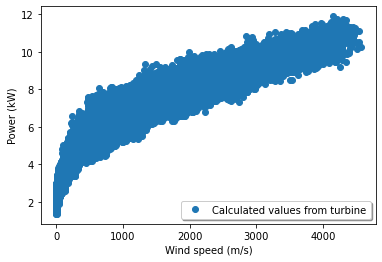

In [9]:
#Print values - calculated values
fig, ax = plt.subplots()

ax.plot(dfcalc["Loc/Wec/CalcP"], dfcalc["Loc/Wec/CalcVwind"],"o",label='Calculated values from turbine')

plt.xlabel("Wind speed (m/s)")
plt.ylabel("Power (kW)")

legend = ax.legend(loc='lower right', shadow=True, fontsize='medium')
plt.show()

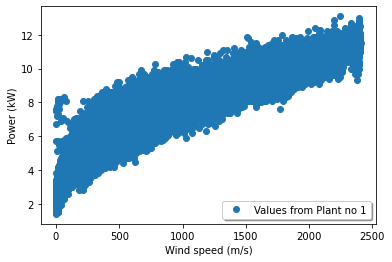

In [10]:
#Print values - turbine 1 
fig, ax = plt.subplots()

ax.plot(dft1["Loc/Wec/Plant1/P"], dft1["Loc/Wec/Plant1/Vwind"],"o",label='Values from Plant no 1')

plt.xlabel("Wind speed (m/s)")
plt.ylabel("Power (kW)")

legend = ax.legend(loc='lower right', shadow=True, fontsize='medium')
plt.show()

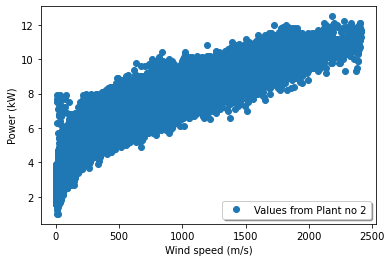

In [11]:
#Print values - turbine 2
fig, ax = plt.subplots()

ax.plot(dft2["Loc/Wec/Plant2/P"], dft2["Loc/Wec/Plant2/Vwind"],"o",label='Values from Plant no 2')

plt.xlabel("Wind speed (m/s)")
plt.ylabel("Power (kW)")

legend = ax.legend(loc='lower right', shadow=True, fontsize='medium')
plt.show()

### Anomalies
#### Different values of Power for same value of Wind speed

In [12]:
dfcalc[dfcalc["Loc/Wec/CalcVwind"] == 1.9]

valuename,Date,Time,Loc/Wec/CalcP,Loc/Wec/CalcVwind
9069,2021-07-05,20:03:58,14.0,1.9
9160,2021-07-05,20:06:21,2.0,1.9
9168,2021-07-05,20:06:34,3.0,1.9
9183,2021-07-05,20:07:38,8.0,1.9
9187,2021-07-05,20:07:45,6.0,1.9
...,...,...,...,...
154748,2021-07-08,13:50:57,3.0,1.9
154762,2021-07-08,13:51:29,1.0,1.9
154779,2021-07-08,13:51:56,9.0,1.9
154785,2021-07-08,13:52:06,8.0,1.9


In [13]:
dft1[(dft1["Loc/Wec/Plant1/Vwind"] == 3.5)]

valuename,Date,Time,Loc/Wec/Plant1/P,Loc/Wec/Plant1/Vwind
131,2021-07-05,16:09:25,148.0,3.5
143,2021-07-05,16:09:44,131.0,3.5
146,2021-07-05,16:09:48,127.0,3.5
149,2021-07-05,16:09:52,121.0,3.5
541,2021-07-05,16:20:12,36.0,3.5
...,...,...,...,...
156371,2021-07-08,14:52:11,31.0,3.5
156387,2021-07-08,14:52:36,31.0,3.5
156437,2021-07-08,14:53:55,31.0,3.5
156438,2021-07-08,14:53:56,32.0,3.5


In [14]:
dft2[(dft2["Loc/Wec/Plant2/Vwind"] == 3.5)]

valuename,Date,Time,Loc/Wec/Plant2/P,Loc/Wec/Plant2/Vwind
21,2021-07-05,16:06:30,117.0,3.5
30,2021-07-05,16:06:45,93.0,3.5
85,2021-07-05,16:08:12,110.0,3.5
149,2021-07-05,16:09:53,80.0,3.5
170,2021-07-05,16:10:25,69.0,3.5
...,...,...,...,...
154805,2021-07-08,14:43:09,26.0,3.5
155058,2021-07-08,14:49:46,24.0,3.5
155060,2021-07-08,14:49:49,24.0,3.5
155100,2021-07-08,14:50:51,27.0,3.5


## Clean the dataset

### Calculated values

In [15]:
#empthy df
df_calc = pd.DataFrame()

#group by wind and calculate the median power
df_calc['Median_power'] = dfcalc.groupby('Loc/Wec/CalcVwind')['Loc/Wec/CalcP'].transform('median')

#append new median power values to df
dfcalc = pd.concat([dfcalc, df_calc], axis=1, join="inner")

#store df
%store dfcalc

dfcalc.head(5)

Stored 'dfcalc' (DataFrame)


,Date,Time,Loc/Wec/CalcP,Loc/Wec/CalcVwind,Median_power
0,2021-07-05,16:05:16,341.0,4.80,370.0
1,2021-07-05,16:05:17,340.0,4.70,330.0
2,2021-07-05,16:05:19,336.0,4.85,378.0
3,2021-07-05,16:05:21,338.0,4.45,274.0
4,2021-07-05,16:05:22,330.0,4.45,274.0


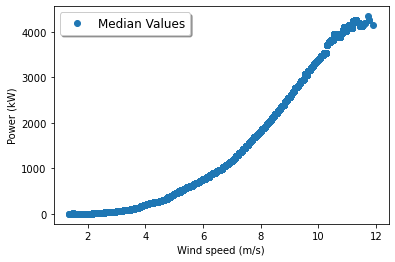

In [16]:
fig, ax = plt.subplots()

ax.plot(dfcalc["Loc/Wec/CalcVwind"], dfcalc["Median_power"],"o",label='Median Values')

plt.xlabel("Wind speed (m/s)")
plt.ylabel("Power (kW)")

legend = ax.legend(loc='upper left', shadow=True, fontsize='large')
plt.show()

### Turbine 1

In [17]:
#empthy df
df_t1 = pd.DataFrame()

#group by wind and calculate the median power
df_t1['Median_power'] = dft1.groupby('Loc/Wec/Plant1/Vwind')['Loc/Wec/Plant1/P'].transform('median')

#append new median power values to df
dft1 = pd.concat([dft1, df_t1], axis=1, join="inner")

#store df
%store dft1

dft1.head(5)

Stored 'dft1' (DataFrame)


,Date,Time,Loc/Wec/Plant1/P,Loc/Wec/Plant1/Vwind,Median_power
0,2021-07-05,16:05:16,224.0,5.1,231.0
1,2021-07-05,16:05:17,221.0,4.9,195.0
2,2021-07-05,16:05:19,221.0,5.1,231.0
3,2021-07-05,16:05:21,220.0,4.8,177.0
4,2021-07-05,16:05:22,217.0,4.8,177.0


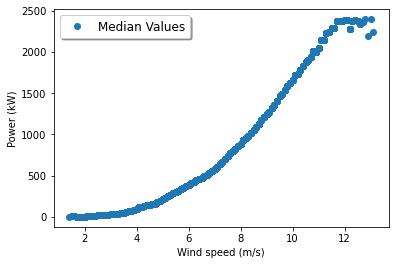

In [18]:
fig, ax = plt.subplots()

ax.plot(dft1["Loc/Wec/Plant1/Vwind"], dft1["Median_power"],"o",label='Median Values')

plt.xlabel("Wind speed (m/s)")
plt.ylabel("Power (kW)")

legend = ax.legend(loc='upper left', shadow=True, fontsize='large')
plt.show()

### Turbine 2

In [19]:
#empthy df
df_t2 = pd.DataFrame()

#group by wind and calculate the median power
df_t2['Median_power'] = dft2.groupby('Loc/Wec/Plant2/Vwind')['Loc/Wec/Plant2/P'].transform('median')

#append new median power values to df
dft2 = pd.concat([dft2, df_t2], axis=1, join="inner")

#store df
%store dft2

dft2.head(5)

Stored 'dft2' (DataFrame)


,Date,Time,Loc/Wec/Plant2/P,Loc/Wec/Plant2/Vwind,Median_power
0,2021-07-05,16:05:15,117.0,4.5,140.0
1,2021-07-05,16:05:17,120.0,4.4,131.0
2,2021-07-05,16:05:19,117.0,4.3,121.0
3,2021-07-05,16:05:20,118.0,4.1,108.0
4,2021-07-05,16:05:23,117.0,4.1,108.0


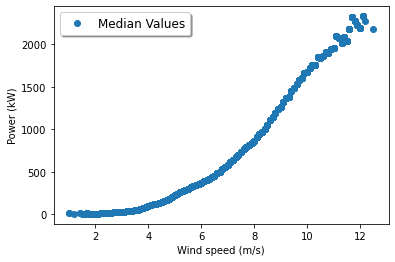

In [20]:
fig, ax = plt.subplots()

ax.plot(dft2["Loc/Wec/Plant2/Vwind"], dft2["Median_power"],"o",label='Median Values')

plt.xlabel("Wind speed (m/s)")
plt.ylabel("Power (kW)")

legend = ax.legend(loc='upper left', shadow=True, fontsize='large')
plt.show()